# Define paths

In [228]:
from pathlib import Path

project_folder = str(Path(Path.cwd()).parents[1])

plots_folder = project_folder + "/TeX/figs/"

# Import solar model

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

solar_model = pd.read_csv("./Data/bs2005agsopflux.csv", 
                          usecols=[1, 3, 7, 13],
                          names = ['radius', 'density_log_10', '8B fraction', 'hep fraction'],
                          sep=" ", skiprows=27, header=None)

solar_model['density'] = 10**solar_model['density_log_10']
solar_model

,radius,density_log_10,8B fraction,hep fraction,density
0,0.00041,2.011,0.000005,1.661000e-07,102.565193
1,0.00082,2.011,0.000014,4.865000e-07,102.565193
2,0.00123,2.011,0.000023,8.074000e-07,102.565193
3,0.00164,2.011,0.000035,1.245000e-06,102.565193
4,0.00205,2.011,0.000053,1.857000e-06,102.565193
...,...,...,...,...,...
1214,0.49795,0.071,0.000000,2.902000e-10,1.177606
1215,0.49836,0.069,0.000000,2.843000e-10,1.172195
1216,0.49877,0.067,0.000000,2.785000e-10,1.166810
1217,0.49918,0.065,0.000000,2.728000e-10,1.161449


<AxesSubplot:xlabel='r', ylabel='$n_e(r)$ [mol/cm${}^3$]'>

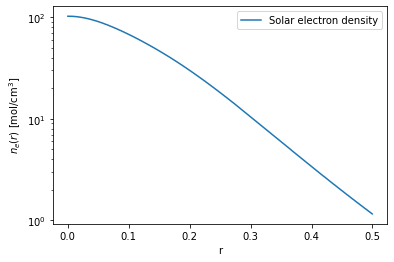

In [3]:
plot = solar_model.plot(x='radius', y='density', logy=True)
plot.set_xlabel("r")
plot.set_ylabel("$n_e(r)$ [mol/cm${}^3$]")
plot.legend(labels=['Solar electron density'])

plt.savefig(plots_folder + "sun_density.pdf")

plot

# Compute solar neutrino survival probability at Sun surface

In [4]:
def Vk(Deltam2, E, ne):
    """Vk(Deltam2, E, ne) computes the ratio V/k between the matter and vacuum terms in neutrino oscillations.
    - Deltam2 is the squared mass difference, in units of eV^2;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density, in units of mol/cm^3;
See also Eq.s 4.17, 4.18 in 1802.05781."""
    return (3.868e-7)/(2.533) * (ne / (Deltam2 / E))

In [5]:
from numpy import cos, sin, arcsin, tan, arctan, pi

def th12_M (th12, th13, DeltamSq21, E, ne):
    """th12_M(th12, th13, DeltamSq21, E, ne) computes the mixing angle \theta_{12} in matter.
    - th1j are the vacuum mixing angles in radians;
    - DeltamSq21 is the vacuum squared mass difference between mass eigenstates 2 and 1;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density, in units of mol/cm^3.
See also Eq. 1.22 in FiuzadeBarros:2011qna."""
    return (arctan(tan(2*th12) / (1 - (cos(th13)**2)/(cos(2* th12)) * Vk(DeltamSq21, E, ne))) / 2) % (pi/2)


def th13_M (th13, DeltamSq31, E, ne):
    """th13_M(th13, DeltamSq31, E, ne) computes the mixing angle \theta_{13} in matter.
    - th13 is the vacuum mixing angles \theta_{13} in radians;
    - DeltamSq31 is the vacuum squared mass difference between mass eigenstates 3 and 1;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density, in units of mol/cm^3.
See also Eq. 1.22 in FiuzadeBarros:2011qna."""
    return (arcsin(sin(th13) * (1 + Vk(DeltamSq31, E, ne) * cos(th13)**2))) % (pi/2)

In [6]:
def Pnuenue (th12, th13, DeltamSq21, DeltamSq31, E, ne):
    """Pnuenue(th12, th13, DeltamSq21, DeltamSq31, E, ne) computes the survival probability of an electron neutrino
    neutrino at the Sun surface in the adiabatic approximation, as a function of vacuum oscillation parameters.
    - th1j are the vacuum mixing angles in radians;
    - DeltamSqj1 are the vacuum squared mass difference between mass eigenstates 2 and 1;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density at neutrino production point, in units of mol/cm^3.
See also Eq. 6.14 in FiuzadeBarros:2011qna."""
    th12m = th12_M(th12, th13, DeltamSq21, E, ne)
    th13m = th13_M(th13, DeltamSq31, E, ne)
    return cos(th13)**2 * cos(th13m)**2 * (cos(th12)**2 * cos(th12m)**2 + sin(th12)**2 * sin(th12m)**2) + sin(th13)**2 * sin(th13m)**2

<AxesSubplot:xlabel='r', ylabel='Neutrino fraction'>

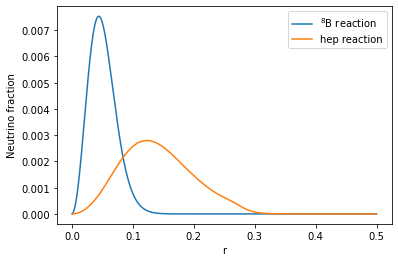

In [7]:
plot = solar_model.plot(x='radius', y=['8B fraction', 'hep fraction'])
plot.set_xlabel('r')
plot.set_ylabel('Neutrino fraction')
plot.legend(labels=['${}^8$B reaction', 'hep reaction'])

plt.savefig(plots_folder + "reaction_fraction.pdf")

plot

In [8]:
from scipy import integrate
import numpy as np

def PnuenueReaction (th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, fraction):
    """PnuenueReaction (th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, fraction) computes the
    survival probability at Sun surface for an electron with energy E produced in a specific reaction.
    - th1j are the vacuum mixing angles in radians;
    - DeltamSqj1 are the vacuum squared mass difference between mass eigenstates 2 and 1;
    - E is the neutrino energy, in units of MeV;
    - radius_samples is a list of solar relative radius values where density and fraction are sampled;
    - density is the list of electron densities at radii radius_samples, in units of mol/cm^3;
    - fraction is the relative fraction of neutrinos produced in the considered reaction, sampled at radius_samples."""
    
    IntegratedFraction = integrate.trapezoid(y=fraction, x=radius_samples)
    PnuenueRadius = np.array([Pnuenue(th12, th13, DeltamSq21, DeltamSq31, E, ne_r) for ne_r in density])
    
    return integrate.trapezoid(y=(PnuenueRadius * fraction), x = radius_samples) / IntegratedFraction

In [9]:
from math import sqrt

th12 = arctan(sqrt(0.469))
th13 = arcsin(sqrt(0.01))
DeltamSq21 = 7.9e-5
DeltamSq31 = 2.46e-3
E = 10
ne = 100
radius_samples = solar_model.radius
density = solar_model.density
fraction = solar_model['8B fraction']

xrange = np.arange(1,20,0.1)
ProbB8 = [PnuenueReaction(th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, solar_model['8B fraction']) for E in xrange]
Probhep = [PnuenueReaction(th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, solar_model['hep fraction']) for E in xrange]

In [10]:
SNO_B8 = pd.read_csv("./Data/B8.csv", names=['energy', 'Pnuenue'])
SNO_hep = pd.read_csv("./Data/hep.csv", names=['energy', 'Pnuenue'])

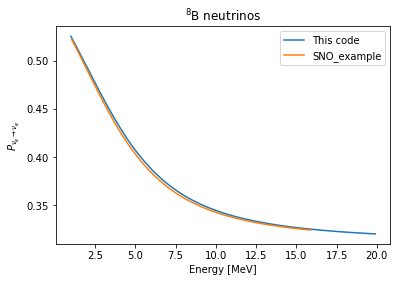

In [11]:
plt.plot(xrange, ProbB8, label="This code")
plt.plot(SNO_B8.energy, SNO_B8.Pnuenue, label='SNO_example')
plt.title("${}^8$B neutrinos")
plt.xlabel('Energy [MeV]')
plt.ylabel(r"$P_{\nu_e \rightarrow \nu_e}$")
plt.legend()
plt.savefig(plots_folder + "8B_SNO_cmparison.pdf")

plt.show()

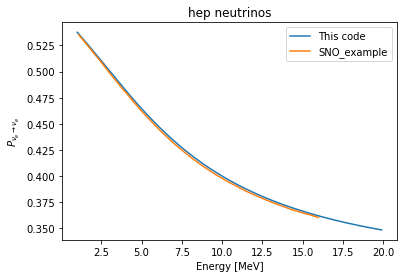

In [12]:
plt.plot(xrange, Probhep, label="This code")
plt.plot(SNO_hep.energy, SNO_hep.Pnuenue, label='SNO_example')
plt.title("hep neutrinos")
plt.xlabel('Energy [MeV]')
plt.ylabel(r"$P_{\nu_e \rightarrow \nu_e}$")
plt.legend()
plt.savefig(plots_folder + "hep_SNO_comparison.pdf")

plt.show()

# Earth regeneration

### It is not necessary to define a new function for undergroud detector:
- for $0 \leq \eta \leq \pi/2$: use total path for first half of propagation, then stop at $r_{det} = 1 - h$ for second half;
- for $\pi/2 \leq \eta \leq \pi$: just use downstream path (with constant density? The density variation is at most $10^{-4}$ for SNO)

In [86]:
import numpy as np
from math import sin, cos, sqrt

def EarthDensity (x = 0, eta = 0, integrated = False): 
    """EarthDensity(x, eta, integrated) computes:
    - if integrated = False: the value of Earth electron density in units of mol/cm^3 for trajectory coordinate 
    x and nadir angle eta;
    -if integrated = True: two lists containing the values of the integrated electron 
    densities along each shell crossed by a path with nadir angle eta, to be inputed in 
    the 1st and 2nd order terms in the evolutor Magnus expansion.
See hep-ph/9702343 for the definition of trajectory coordinate."""
    
    # If x > cos(eta) the trajectory coordinate is beyond Earth surface, thus density is zero.
    if ((~integrated) & (x > cos(eta))):
        return 0
    else:
        # Define the Earth density parametrisation, in units of mol/cm^3, following hep-ph/9702343
        alpha = np.array([6.099, 5.803, 3.156, -5.376, 11.540])
        beta = np.array([-4.119, -3.653, -1.459, 19.210, -20.280])
        gamma = np.array([0, -1.086, 0.280, -12.520, 10.410])

        rj = np.array([0.192, 0.546, 0.895, 0.937, 1])

        # Select the index "idx_shells" in rj such that for i >= idx_shells => rj[i] > sin(eta)
        # The shells having rj[i] > sin(eta) are the ones crossed by a path with nadir angle = eta
        idx_shells = np.searchsorted(rj, sin(eta))
        
        # Keep only the parameters for the shells crossed by the path with nadir angle eta
        alpha_prime = alpha[idx_shells::] + beta[idx_shells::] * sin(eta)**2 + gamma[idx_shells::] * sin(eta)**4
        beta_prime = beta[idx_shells::] + 2 * gamma[idx_shells::] * sin(eta)**2
        gamma_prime = gamma[idx_shells::]

        # Compute the value of the trajectory coordinates xj at each shell crossing
        xj = np.sqrt( (rj[idx_shells::])**2 - sin(eta)**2 )

        # The index "idx" determines within which shell xj[idx] the point x is
        idx = np.searchsorted(xj, x)
        
        # If integrated = true, the function returns the values of the integrated electron densities for the
        # path along each crossed shell
        if integrated:
            # Define xj_zero, a list containing the values of trajectory coordinates for each shell boundary
            # (including the lower end x = 0), user to perform integration on each shell
            xj_zero = np.insert(xj, 0, 0)
            
            # Return the value of the integrated densities along each crossed shell
            return [
                [(xj_zero[i+1] - xj_zero[i]) for i in range(len(alpha_prime))],
                [(alpha_prime[i] * (xj_zero[i+1] - xj_zero[i]) + beta_prime[i] * (xj_zero[i+1]**3 - xj_zero[i]**3) / 3 + gamma_prime[i] * (xj_zero[i+1]**5 - xj_zero[i]**5) / 5) for i in range(len(alpha_prime))],
                [( (xj_zero[i+1] - xj_zero[i])**3 * (xj_zero[i+1] + xj_zero[i]) * (5 * beta_prime[i] + 2 * gamma_prime[i] * (2 * xj_zero[i]**2 + 2 * xj_zero[i+1]**2 + xj_zero[i]*xj_zero[i+1])) / 30) for i in range(len(alpha_prime))]
            ]
       
        # If integrated = False, return the value of electron density at trajectory point x for nadir angle eta
        else:
            return alpha_prime[idx] + beta_prime[idx] * x**2 + gamma_prime[idx] * x**4

NameError: name 'plots_folder' is not defined

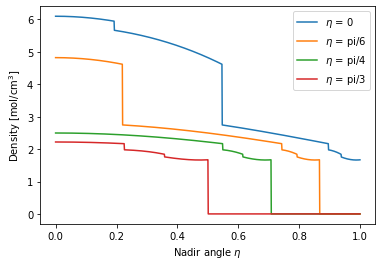

In [87]:
import matplotlib.pyplot as plt
from math import pi

x = np.arange(0,1,0.001)
eta = [0, pi/6, pi/4, pi/3]
labels = ["0", "pi/6", "pi/4", "pi/3"]

density = [ [EarthDensity(r, n) for r in x] for n in eta]

plt.xlabel("Nadir angle $\eta$")
plt.ylabel("Density [mol/cm${}^3$]")
for i in range(len(density)):
    plt.plot(x,density[i], label = "$\eta$ = %s" %labels[i])
plt.legend()
plt.savefig(plots_folder + "earth_density.pdf")
    
plt.show()

In [25]:
h = 2 / 6.371e3

(EarthDensity(1) - EarthDensity(1-h))/(EarthDensity(1) + EarthDensity(1-h))

0.00010027377254072573

In [196]:
DeltamSq21 = 7.42e-5
DeltamSq31 = 2.514e-3
E = 10
[th12, th13, th23, d] = [0.583638, 0.149575, 0.855211, 3.40339]
eta = 0

from math import sin, cos
from cmath import exp
from scipy.linalg import expm
from numpy.linalg import multi_dot

R_E = 6.371e6 # meters

def R23(th):
    return np.matrix([
        [1, 0, 0],
        [0, cos(th), sin(th)],
        [0, -sin(th), cos(th)]
    ])

def R13(th):
    return np.matrix([
        [cos(th), 0, sin(th)],
        [0, 1, 0],
        [-sin(th), 0, cos(th)]
    ])

def R12(th):
    return np.matrix([
        [cos(th), sin(th), 0],
        [-sin(th), cos(th), 0],
        [0, 0, 1]
    ])

def Delta(d):
    return np.matrix([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, exp(1j*d)]
    ])


[k1, k2, k3] = 2.533 * np.array([0, DeltamSq21, DeltamSq31]) / E

r13 = R13(th13)
r12 = R12(th12)
r23 = R23(th23)
delta = Delta(d)

pmns = multi_dot([r23, delta, r13, delta.conjugate(), r12])

k = np.matrix(np.diag([k1, k2, k3]))

H0 = r13 * r12 * k * r12.transpose() * r13.transpose()

H2_12 = (k2 - k1) * cos(th12) * cos(th13) * sin(th12)
H2_13 = sin(th13) * cos(th13) * ((k2 - k1) * (2 * cos(th12)**2 - 1) + 2 * k3 - k1 - k2) / 2
H2 = np.array([
    [0, H2_12, H2_13],
    [-H2_12, 0, 0],
    [-H2_13, 0, 0]
])

ME_density = EarthDensity(eta=eta, integrated=True)

# Need to understand if R_E or R_E^2 in ME2!
ME1 = [- 1j * R_E * (H0 * ME_density[0][shell] + np.diag([3.868e-7 * (ME_density[1][shell]), 0, 0]) ) for shell in range(len(ME_density[0]))]
ME2 = [- np.matrix(R_E**1 * H2 * 3.868e-7 * (ME_density[2][shell]) / 2) for shell in range(len(ME_density[0]))]

ME12 = [expm(ME1[i] + ME2[i]) for i in reversed(range(len(ME1)))]

evolutor_half = multi_dot(ME12)

evolutor = multi_dot([r23, delta.conjugate(), evolutor_half.transpose(), evolutor_half, delta, r23.transpose()])

probabilities = np.square(np.abs(evolutor * pmns[:,1]))

In [197]:
probabilities

matrix([[0.28859878],
        [0.40303745],
        [0.30836377]])

In [185]:
pmns

matrix([[ 0.82514621+0.00000000e+00j,  0.54491046+0.00000000e+00j,
         -0.14394031+3.85683745e-02j],
        [-0.27087988+2.42894885e-02j,  0.60732118+1.60403043e-02j,
          0.74628265-2.09473927e-17j],
        [ 0.49469387+2.11145445e-02j, -0.57773857+1.39436332e-02j,
          0.64873405-1.82093030e-17j]])

In [195]:
np.square(np.abs(evolutor * pmns[:,1])).sum()

1.0000000000000453

In [189]:
pmns[:,1]

matrix([[ 0.54491046+0.j        ],
        [ 0.60732118+0.0160403j ],
        [-0.57773857+0.01394363j]])

In [118]:
ME12

[array([[ 0.50468944+0.25208973j, -0.67958312+0.40466203j,
         -0.19522786-0.13431623j],
        [-0.67925986+0.40520442j, -0.01352326+0.59970356j,
          0.10193872-0.06478178j],
        [-0.19547505-0.13395618j,  0.10187103-0.06488826j,
         -0.75538793-0.59887071j]]),
 array([[ 0.35463998-0.07815822j, -0.89984458-0.13091367j,
         -0.17525169+0.10271301j],
        [-0.89994938-0.13019095j, -0.33850348-0.19862858j,
          0.13641274+0.02225025j],
        [-0.17505716+0.10304459j,  0.1364366 +0.02210164j,
         -0.77973917+0.5758821j ]]),
 array([[ 0.92511762+0.1608793j , -0.10560707+0.29974631j,
         -0.02323114-0.12936322j],
        [-0.09760951+0.30244798j,  0.84945605+0.41793714j,
          0.0162053 -0.04987946j],
        [-0.03163938-0.12756091j,  0.01429312-0.05047744j,
          0.74843521-0.6479349j ]]),
 array([[ 0.37924069+0.12258838j, -0.86452216+0.24296269j,
         -0.04208778-0.18151521j],
        [-0.85477498+0.27551388j, -0.23747675+0.340166

In [108]:
ME12

[array([[ 0.35446154+0.1603566j , -0.85850541+0.27327093j,
         -0.18524675+0.05116515j],
        [-0.85773658+0.27567542j, -0.22301188+0.34623487j,
          0.13018865-0.04158191j],
        [-0.18476205+0.05288462j,  0.12991719-0.04242753j,
         -0.83521606+0.49679147j]]),
 array([[ 0.37924069+0.12258838j, -0.86452216+0.24296269j,
         -0.04208778-0.18151521j],
        [-0.85477498+0.27551388j, -0.23747675+0.34016677j,
          0.13878856-0.0456172j ],
        [-0.06273686-0.17511283j,  0.1352613 -0.05627001j,
          0.01128084-0.97149905j]]),
 array([[ 0.92511762+0.1608793j , -0.10560707+0.29974631j,
         -0.02323114-0.12936322j],
        [-0.09760951+0.30244798j,  0.84945605+0.41793714j,
          0.0162053 -0.04987946j],
        [-0.03163938-0.12756091j,  0.01429312-0.05047744j,
          0.74843521-0.6479349j ]]),
 array([[ 0.35463998-0.07815822j, -0.89984458-0.13091367j,
         -0.17525169+0.10271301j],
        [-0.89994938-0.13019095j, -0.33850348-0.198628

In [150]:
np.diag([1,2,3])

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])